In [1]:
import numpy as np
import functools as ft
import math
import cmath
import numba
import os
import warnings as wn
from numba import njit, prange, vectorize
from scipy.special import eval_jacobi, hyp2f1
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [20]:
# Must restrict to m_BF^2 <= m^2 <= 0 case due to boundary scaling

d = 4
m = complex(0., 2.)
print("Using m^2 =", (m * m).real)
Dpl = d/2 + 0.5 * cmath.sqrt(d * d + 4.0 * m * m)
Dmin = d/2 - 0.5 * cmath.sqrt(d * d + 4.0 * m * m)
NPOW = 15
J_0 = 1.
LMAX = 6
DX = np.pi/(2*((2**NPOW) + 1))
XGRID = np.linspace(0, np.pi/2, (2 ** NPOW) + 1, dtype=np.double) # romb method requires 2**k + 1 gridpoints
wbar = 1/4

Using m^2 = -4.0


In [21]:
# Test input values
m_BF = - d * d / 4
if (m * m).real < m_BF:
    print("ERROR: Mass-squared must be greater than the " +
         "Breitenlohmer-Freedman bound:", m_BF)
if Dpl.imag == 0: 
    Dpl = Dpl.real
else:
    print("ERROR: Must have real Delta_plus value")                          
if Dmin.imag == 0: 
    Dmin = Dmin.real
else:
    print("ERROR: Must have real Delta_minus value")

In [22]:
# See recursion relationships between Jacobi polynomials

@njit(parallel=True)
def my_jacobi(n, a, b, x):
    if n < 0:
        return 0.
    elif n == 0:
        return J_0
    elif n == 1:
        return (a + 1) + (a + b + 2) * (x - 1) / 2
    else:
        jac_factor = 2 * n + a + b - 1
        outval = jac_factor * ((jac_factor + 1) * (jac_factor - 1) * x + (a * a)\
                               - (b * b)) * my_jacobi(n - 1, a, b, x)
        outval -= 2 * (n + a - 1) * (n + b - 1) * (jac_factor + 1) * my_jacobi(n - 2, a, b, x)
        return outval / (2 * n * (n + a + b) * (jac_factor - 1))
                    
my_jacobi(4, d/2 - 1, Dpl - d/2, np.cos(2 * np.pi/3))

-0.1328124999999994

In [ ]:
# Writing hypergeometric functions that utilized the numba package
# has proved to produce functions that are SLOWER than calling
# built-in functions. Below is an example of the attempt to write
# numba-compliant hypergeometric functions.

"""
# Needed in evalutating the hypergeometric functions

@njit(parallel=True)
def my_factorial(n):
    if n < 0:
        return np.inf
    elif n == 0:
        return 1
    else:
        return n * my_factorial(n - 1)
        
# Express hypergeometric function in terms a finite sum

@njit(parallel=True)
def my_2F1(a, b, c, x):
    tol = 1.E-6
    outval = 1.
    k = 1
    while(True):
        next_term = math.gamma(a + k) * math.gamma(b + k) * math.gamma(0.5 * a + 0.5 * b) * x ** k /\
            (math.gamma(a) * math.gamma(b) * math.gamma(0.5 * a + 0.5 * b + k) * my_factorial(k))
        # Failsafe
        if (k > 1E5):
            print("\nERROR: no convergence in my_2F1\n")
            break
        # When the next term is a less than the specified
        # relative tolerance, return the value
        elif (abs(next_term / outval) < tol):
            break
        # Otherwise, add to the output value, increment and repeat
        else:
            outval += next_term
            k += 1
    return outval

my_2F1((Dpl+wbar)/2, (Dpl-wbar)/2, d/2, np.sin(np.pi/4) ** 2)
    
my_factorial(3)

%timeit my_2F1((Dpl+wbar)/2, (Dpl-wbar)/2, d/2, np.sin(np.pi/4) ** 2)
9.64 µs ± 77.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
"""

In [ ]:
#%timeit hyp2f1((Dpl+wbar)/2, (Dpl-wbar)/2, d/2, np.sin(np.pi/4) ** 2)

In [23]:
@njit(parallel=True)
def mu(x):
    return (np.tan(x)) ** (d-1)

# Evaluate the derivatives analytically
@njit(parallel=True)
def nu(x):
    return (np.cos(x)) ** 2 * (np.tan(x)) ** (2 - d)

@njit(parallel=True)
def nup(x):
    return (1 - d + np.cos(2.*x)) * (np.tan(x)) ** (1 - d) 

@njit(parallel=True)
def omega(i):
    return Dpl + 2 * i
mu(0)
nu(np.pi)
nup(np.pi/4)
omega(0)

2.0

In [24]:
@njit(parallel=True)
def K(i):
    return 2. * np.sqrt((i + Dpl / 2) * math.gamma(i + 1) * math.gamma(Dpl + i) / (math.gamma(i + d/2) * math.gamma(
        i + Dpl + 1 - d/2)))

K(1)

2.8284271247461903

In [25]:
# Since basis functions will be called with either integer arguments (normalizable) or
# non-integer arguments (non-normalizable), write one basis function that returns
# either of these types based on the integer nature of the argument

def e(x, i):
    # If integer is passed, return normalizable solution
    if isinstance(i, int):
        return K(i) * (np.cos(x)) ** Dpl * my_jacobi(i, d/2 - 1, Dpl - d/2, np.cos(2 * x))
    # Otherwise, return NN solution
    else:
        return (np.cos(x)) ** Dpl * hyp2f1((Dpl + i) / 2, (Dpl - i) / 2, d / 2, (np.sin(x)) ** 2)
    
print(e(np.pi/4, 2.0))
print(e(np.pi/4, int(2)))

0.5000000000000001
-0.8660254037844386


In [26]:
# Same thing for the derivatives

def ep(x, i):
    if isinstance(i, int):
        return -1. * K(i) * np.tan(x) * (np.cos(x)) ** Dpl * (2 * (Dpl + i) * np.cos(x) ** 2 * my_jacobi(i - 1, 
            d/2, Dpl + 1 - d/2, np.cos(2 * x)) + Dpl * my_jacobi(i, d/2 - 1, Dpl - d/2, np.cos(2 * x)))
    else:
        return (1. / d) * np.tan(x) * np.cos(x) ** Dpl * ((Dpl ** 2 - i ** 2) * np.cos(x) ** 2 *\
                hyp2f1(1 + 0.5 * (Dpl - i), 1 + 0.5 * (Dpl + i), 1 + 0.5 * d, (np.sin(x)) ** 2)\
                - d * Dpl * hyp2f1(0.5 * (Dpl - i), 0.5 * (Dpl + i), d/2, (np.sin(x)) ** 2))
    
print(ep(np.pi/3, int(1)))
print(ep(np.pi/3, 1.0))

-1.2247448713915912
-0.9631124966492748


In [27]:
# Without parallelizing options, regular scipy integration methods
# outperform approximators by orders of magnitude

# Try to catch convergence problems in integrals and switch to higher
# resolution options

wn.filterwarnings("error")

def X(i,j,k,l):
    def integrand(x, i, j, k, l):
        return mu(x) * np.sin(x) * np.cos(x) * ep(x, i) * e(x, j) * e(x, k) * e(x, l)
    try:
        return integrate.quad(integrand, 0, np.pi/2, args=(i,j,k,l))[0]
    except IntegrationWarning:
        result = integrate.quad(integrand, 0, np.pi/2, args=(i,j,k,l), limit=100)
        print("X(%f,%f,%f,%f):" % (i,j,k,l), result)
        return result[0]

def Y(i,j,k,l):
    def integrand(x, i, j, k, l):
        return mu(x) * np.sin(x) * np.cos(x) * ep(x, i) * ep(x, j) * e(x, k) * ep(x, l)
    try:
        return integrate.quad(integrand, 0, np.pi/2, args=(i,j,k,l))[0]
    except IntegrationWarning:
        result = integrate.quad(integrand, 0, np.pi/2, args=(i,j,k,l), limit=100)
        print("Y(%f,%f,%f,%f):" % (i,j,k,l), result)
        return result[0]

def V(i,j,k,l):
    def integrand(x, i, j, k, l):
        return mu(x) * np.sin(x) * np.cos(x) * e(x, i) * e(x, j) * ep(x, k) * e(x, l) * (1 / np.cos(x)) ** 2
    try:
        return integrate.quad(integrand, 0, np.pi/2, args=(i,j,k,l))[0]
    except IntegrationWarning:
        result = integrate.quad(integrand, 0, np.pi/2, args=(i,j,k,l), limit=100)
        print("V(%f,%f,%f,%f):" % (i,j,k,l), result)
        return result[0]

def B(i,j,l):
    # Note that y MUST preceed x
    def integrand(y, x, i, j, l):
        return np.sin(x) * np.cos(x) * ep(x, i) * ep(x, j) * mu(y) * e(y, l) * e(y, l)
    # Use built-in double integrator with dynamic bounds
    try:
        return integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l))[0]
    except integrate.IntegrationWarning:
        result = integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l),
                               epsrel=1.0e-6)
        print("B(" + str(i) + "," + str(j) + "," + str(l) + ") =", result)
        return result[0]

def P(i,j,l):
    # Note that y MUST preceed x
    def integrand(y, x, i, j, l):
        return np.sin(x) * np.cos(x) * e(x, i) * e(x, j) * mu(y) * e(y, l) * e(y, l)
    # Use built-in double integrator with dynamic bounds
    try:
        return integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l))[0]
    except integrate.IntegrationWarning:
        result = integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l),
                                  epsrel=1.0e-6)
        print("P(%f,%f,%f):" % (i,j,l), result)
        return result[0]

def Q(i,j,l):
    # Note that y MUST preceed x
    def integrand(y, x, i, j, l):
        return np.sin(x) * np.cos(x) * e(x, i) * e(x, j) * (1/ np.cos(x)) ** 2 * mu(y) * e(y, l) * e(y, l)
    # Use built-in double integrator with dynamic bounds
    try:
        return integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l))[0]
    except integrate.IntegrationWarning:
        result = integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l),
                                  epsrel=1.0e-6)
        print("Q(%f,%f,%f):" % (i,j,l), result)
        return result[0]
    
print("X(%f,%f,%f,%f) = %e" % (1,1,1,1, X(1,1,1,1)))
print("Y(%f,%f,%f,%f) = %e" % (0,0.25,0.25,0, Y(0,0.25,0.25,0)))
print("V(%f,%f,%f,%f) = %e" % (0.5,0.5,1,1, V(0.5,0.5,1,1)))
print("B(%f,%f,%f) = %e" % (0,0,0, B(0,0,0)))
print("P(%f,%f,%f) = %e" % (1,0.5,3, P(1,0.5,3)))
print("Q(%f,%f,%f) = %e" % (0.75,2,1, Q(0.75,2,1)))

X(1.000000,1.000000,1.000000,1.000000) = -4.647619e+00
Y(0.000000,0.250000,0.250000,0.000000) = -1.755483e+00
V(0.500000,0.500000,1.000000,1.000000) = -1.120667e+00
B(0.000000,0.000000,0.000000) = 4.000000e-01
P(1.000000,0.500000,3.000000) = 1.500789e-01
Q(0.750000,2.000000,1.000000) = -3.257034e-02


In [ ]:
#%timeit V_temp(0.5, 0.5, 1, 1)

In [28]:
# NB. May be passing non-integer indices for i, j, or k.

def H(i,j,k,l):
    # Only i and k need to be tested as integers
    if isinstance(i, int):
        if isinstance(j, int):
            return omega(i) ** 2 * X(k,i,j,l) + omega(k) ** 2 * X(i,j,k,l) \
                    - Y(i,j,l,k) - Y(l,k,j,i) - (m * m).real * (V(i,j,k,l) + V(k,j,i,l))
        else:
            return omega(i) ** 2 * X(k,i,j,l) + k ** 2 * X(i,j,k,l) \
                    - Y(i,j,l,k) - Y(l,k,j,i) - (m * m).real * (V(i,j,k,l) + V(k,j,i,l))
    elif not isinstance(i, int):
        if isinstance(k, int):
            return i ** 2 * X(k,i,j,l) + omega(k) ** 2 * X(i,j,k,l) \
                    - Y(i,j,l,k) - Y(l,k,j,i) - (m * m).real * (V(i,j,k,l) + V(k,j,i,l))
        else:
            return i ** 2 * X(k,i,j,l) + k ** 2 * X(i,j,k,l) \
                    - Y(i,j,l,k) - Y(l,k,j,i) - (m * m).real * (V(i,j,k,l) + V(k,j,i,l))
    else:
        print("\nERROR: Failure to parse arguments in H\n")

def Zpl(i,j,k,l):
    # Only i and j need to be tested
    if isinstance(i, int):
        if isinstance(j, int):
            return omega(i) * omega(j) * (X(k,l,i,j) - X(l,k,i,j)) \
                    + (Y(i,j,l,k) - Y(i,j,k,l))
        else:
            return omega(i) * j * (X(k,l,i,j) - X(l,k,i,j)) \
                    + (Y(i,j,l,k) - Y(i,j,k,l))
    elif not isinstance(i, int):
        if isinstance(j, int):
            return i * omega(j) * (X(k,l,i,j) - X(l,k,i,j)) \
                    + (Y(i,j,l,k) - Y(i,j,k,l))
        else:
            return i * j * (X(k,l,i,j) - X(l,k,i,j)) \
                    + (Y(i,j,l,k) - Y(i,j,k,l))
    else:
        print("\nERROR: Failure to parse arguments in Zpl\n")

def Zmin(i,j,k,l):
    # Only i and j need to be tested
    if isinstance(i, int):
        if isinstance(j, int):
            return omega(i) * omega(j) * (X(k,l,i,j) - X(l,k,i,j)) \
                    - (Y(i,j,l,k) - Y(i,j,k,l))
        else:
            return omega(i) * j * (X(k,l,i,j) - X(l,k,i,j)) \
                    - (Y(i,j,l,k) - Y(i,j,k,l))
    elif not isinstance(i, int):
        if isinstance(j, int):
            return i * omega(j) * (X(k,l,i,j) - X(l,k,i,j)) \
                    - (Y(i,j,l,k) - Y(i,j,k,l))
        else:
            return i * j * (X(k,l,i,j) - X(l,k,i,j)) \
                    - (Y(i,j,l,k) - Y(i,j,k,l))
    else:
        print("\nERROR: Failure to parse arguments in Zmin\n")
        
def Zpl_tilde(i,j,l):
    # Only i and j need to be tested
    if isinstance(i, int):
        if isinstance(j, int):
            return omega(i) * omega(j) * P(i,j,l) + B(i,j,l)
        else:
            return omega(i) * j * P(i,j,l) + B(i,j,l)
    elif not isinstance(i, int):
        if isinstance(j, int):
            return i * omega(j) * P(i,j,l) + B(i,j,l)
        else:
            return i * j * P(i,j,l) + B(i,j,l)
    else:
        print("\nERROR: Failure to parse arguments in Zpl_tilde\n")

def Zmin_tilde(i,j,l):
    # Only i and j need to be tested
    if isinstance(i, int):
        if isinstance(j, int):
            return omega(i) * omega(j) * P(i,j,l) - B(i,j,l)
        else:
            return omega(i) * j * P(i,j,l) - B(i,j,l)
    elif not isinstance(i, int):
        if isinstance(j, int):
            return i * omega(j) * P(i,j,l) - B(i,j,l)
        else:
            return i * j * P(i,j,l) - B(i,j,l)
    else:
        print("\nERROR: Failure to parse arguments to Zmin_tilde\n")

def M(i,j,l):
    # Only i needs to be tested
    if isinstance(i, int):
        return omega(i) ** 2 * P(i,j,l) - B(i,j,l) - (m * m).real * Q(i,j,l)
    elif not isinstance(i, int):
        return i ** 2 * P(i,j,l) - B(i,j,l) - (m * m).real * Q(i,j,l)
    else:
        print("\nERROR: Failure to parse arguments in M\n")

In [38]:
# Special values of B(l,l,w) that have been calculated with more flexible 
# methods in Mathematica. Read in the file that contains columns of values
# with the first number in each row denoting the value of w and subsequent
# entries in that row the values of B[0,..,10]
bdata = {}
data = np.genfromtxt("data/Bvalues_highres.txt", delimiter=',')
for i in range(data.shape[0]):
    bdata[data[i,0]] = data[i,1:]

# Import Q(i,j,l) from Mathematica as well
qdata = {}
data = np.genfromtxt("data/Qvalues_highres.txt", delimiter=',')
for i in range(data.shape[0]):
    qdata[data[i,0]] = data[i,1:]

def Que(i,j,l):
    if i == j:
        if l in qdata:
            return qdata.get(l)[int(i)]
        else:
            print("\nERROR: no NN frequency %f found in qdata" % l)
            return None
    else:
        print("\nERROR: Que is only valid for i == j, but was given i = %d, j = %d" % (i,j))
        return None

def Bee(i,j,l):
    if i == j:
        if l in bdata:
            return bdata.get(l)[int(i)]
        else:
            print("\nERROR: no NN frequency %f found in bdata" % l)
            return None
    else:
        print("\nERROR: Bee is only valid for i == j, but was given i = %d, j = %d" % (i,j))
        return None
           
def Emm(i,j,l):
    if isinstance(i, int):
        return omega(i) ** 2 * P(i,j,l) - Bee(i,j,l) - (m * m).real * Que(i,j,l)
    elif not isinstance(i, int):
        return i ** 2 * P(i,j,l) - Bee(i,j,l) - (m * m).real * Que(i,j,l)
    else:
        print("ERROR: could not parse Emm(%d,%d,%d)" % (i,j,l))
        return None

print("B:", bdata)
print("Q:", qdata)

B: {1.75: array([0.11727544, 0.46897998, 0.84699397, 1.33128643, 1.94409884,
       2.68956197, 3.56897497, 4.58285799, 5.73145689, 7.01490083,
       8.43325542]), 1.85: array([0.1102684 , 0.45294439, 0.82262643, 1.29320043, 1.88814941,
       2.61170787, 3.46520316, 4.44916558, 5.5638457 , 6.80937503,
       8.18582058]), 1.95: array([0.10338334, 0.43672558, 0.79804704, 1.25477766, 1.83169504,
       2.53313993, 3.36046908, 4.31422345, 5.39465853, 6.60190746,
       7.93604164]), 2.0: array([0.1       , 0.42857143, 0.78571425, 1.23549777, 1.80336327,
       2.49370682, 3.30789926, 4.24648742, 5.30972942, 6.49775955,
       7.81065006]), 2.05: array([0.09666267, 0.42039981, 0.77337128, 1.21620166, 1.77500578,
       2.45423464, 3.25527514, 4.178679  , 5.22470719, 6.39349552,
       7.6851168 ]), 2.15: array([0.09014372, 0.40403983, 0.74870704, 1.1776449 , 1.71833715,
       2.37534789, 3.15009539, 4.04314329, 5.05475808, 6.18507818,
       7.43417796]), 2.25: array([0.0838585 , 0.3877

In [ ]:
# Test values of basis functions by comparing the source term for +++ resonances
# in the normalizable case computed using the non-/normalizable basis functions
# (See DrivenTTF_NormalizableResonances for this calculation)

# Values are consistant with zero up to round off error

"""
def Omega(i,j,k,l):
    return (-1./12) * H(i,j,k,l) * omega(j) * (omega(i) + omega(k) +        
        2 * omega(j)) / ((omega(i) + omega(j)) * (omega(j) + omega(k))) \
        - (1./12) * H(i,k,j,l) * omega(k) * (omega(i) + omega(j) + 
        2 * omega(k)) / ((omega(i) + omega(k)) * (omega(j) + omega(k))) \
        - (1./12) * H(j,i,k,l) * omega(i) * (omega(j) + omega(k) + 
        2 * omega(i)) / ((omega(i) + omega(j)) * (omega(i) + omega(k))) \
        - (1./12) * m ** 2 * V(i,j,k,l) * (1 + omega(j) / (omega(j) + omega(k))
        + omega(i) / (omega(i) + omega(k))) \
        - (1./12) * m ** 2 * V(j,k,i,l) * (1 + omega(j) / (omega(i) + omega(j))
        + omega(k) / (omega(i) + omega(k))) \
        - (1./12) * m ** 2 * V(k,i,j,l) * (1 + omega(i) / (omega(i) + omega(j))
        + omega(k) / (omega(j) + omega(k))) \
        + (1./6) * X(j,k,i,l) * omega(i) * omega(k) * (1 + omega(i) / (omega(j)
        + omega(k)) + omega(k) / (omega(i) + omega(j))) \
        + (1./6) * X(k,i,j,l) * omega(i) * omega(j) * (1 + omega(i) / (omega(j) 
        + omega(k)) + omega(j) / (omega(i) + omega(k))) \
        + (1./6) * X(i,j,k,l) * omega(j) * omega(k) * (1 + omega(j) / (omega(i) 
        + omega(k)) + omega(k) / (omega(i) + omega(j))) \
        - (1./12) * Zmin(i,j,k,l) * omega(k) / (omega(i) + omega(j)) \
        - (1./12) * Zmin(i,k,j,l) * omega(j) / (omega(i) + omega(k)) \
        - (1./12) * Zmin(j,k,i,l) * omega(i) / (omega(j) + omega(k))

Dpl = 4
for l in range(6):
    for i in range(6):
        for j in range(6):
            if (l - i - j - Dpl >= 0):
                print("O(%d,%d,%d,%d) = %e" % (i,j,l-i-j-Dpl,l,Omega(i, j, l - i - j - Dpl, l)))
            else:
                pass
"""

In [33]:
# Source term for equal, general NN frequencies

def Tbar(w, l):
    # Special case for when NN frequency equals resonant frequency
    if w == omega(l):
        if (m * m).real == 0:
            return - w ** 2 * X(l, l, w, w) + (omega(l)) ** 2 * Zpl_tilde(w, w, l) \
                    - 0.5 * H(w, w, l, l) + (omega(l)) ** 2 * X(w, w, l, l) \
                    - 2. * w ** 2 * (omega(l)) ** 2 * P(l, l, w) - w ** 2 * omega(l) ** 2 * P(l, l, w) \
                    + (omega(l)) ** 2 * B(l, l, w)
        else:
            return - w ** 2 * X(l, l, w, w) + (omega(l)) ** 2 * Zpl_tilde(w, w, l) \
                    - 0.5 * H(w, w, l, l) + (omega(l)) ** 2 * X(w, w, l, l) \
                    - 2. * w ** 2 * (omega(l)) ** 2 * P(l, l, w) - w ** 2 * omega(l) ** 2 * P(l, l, w) \
                    + (omega(l)) ** 2 * Bee(l, l, w) \
                    - 3. * (m * m).real * V(l, l, w, w) / 2. - (m * m).real * V(w, w, l, l) / 2.
                
    else:
        if (m * m).real == 0:
            return 0.5 * Zmin(l,w,w,l) * w / (omega(l) + w) \
                    + 0.5 * Zpl(l,w,w,l) * w / (omega(l) - w) \
                    - omega(l) ** 2 * H(w,l,w,l) / (omega(l) ** 2 - w ** 2) \
                    + w ** 2 * H(l,w,w,l) / (omega(l) ** 2 - w ** 2) \
                    + 2 * w ** 2 * (omega(l)) ** 2 * X(w, w, l, l) / (omega(l) ** 2 - w ** 2) \
                    - 2 * w ** 4 * X(l, l, w, w) / (omega(l) ** 2 - w ** 2) \
                    - w ** 2 * X(l, l, w, w) + (omega(l)) ** 2 * Zpl_tilde(w, w, l) \
                    - 0.5 * H(w, w, l, l) + (omega(l)) ** 2 * X(w, w, l, l) \
                    - 2. * w ** 2 * (omega(l)) ** 2 * P(l, l, w) - w ** 2 * omega(l) ** 2 * P(l, l, w) \
                    + (omega(l)) ** 2 * Bee(l, l, w)
        else:
            return 0.5 * Zmin(l,w,w,l) * w / (omega(l) + w) \
                    + 0.5 * Zpl(l,w,w,l) * w / (omega(l) - w) \
                    - omega(l) ** 2 * H(w,l,w,l) / (omega(l) ** 2 - w ** 2) \
                    + w ** 2 * H(l,w,w,l) / (omega(l) ** 2 - w ** 2) \
                    + 2 * w ** 2 * (omega(l)) ** 2 * X(w, w, l, l) / (omega(l) ** 2 - w ** 2) \
                    - 2 * w ** 4 * X(l, l, w, w) / (omega(l) ** 2 - w ** 2) \
                    - w ** 2 * X(l, l, w, w) + (omega(l)) ** 2 * Zpl_tilde(w, w, l) \
                    - 0.5 * H(w, w, l, l) + (omega(l)) ** 2 * X(w, w, l, l) \
                    - 2. * w ** 2 * (omega(l)) ** 2 * P(l, l, w) - w ** 2 * omega(l) ** 2 * P(l, l, w) \
                    + (omega(l)) ** 2 * Bee(l, l, w) \
                    - 3. * (m * m).real * V(l, l, w, w) / 2. - (m * m).real * V(w, w, l, l) / 2.  \
                    - (m * m).real * (omega(l)) ** 2 * V(l, w, w, l) / (omega(l) ** 2 - w ** 2) \
                    + (m * m).real * w ** 2 * V(w, w, l, l) / (omega(l) ** 2 - w ** 2)
                    


def Source(w, Lmax):
    if w <= 0.:
        print("\nERROR: Frequency of NN modes must be greater than or equal to zero.\n")
        return None
    else:
        outval = np.zeros((Lmax + 1,), dtype=np.double)
        for l in range(Lmax + 1):
            outval[l] += Tbar(w,int(l))
            #print("S[%d] = %e" % (i, outval[i]))
        #print("Sum_0^%d S_i = %e" % (l, np.sum(outval)))
        return outval

print("With integer NN frequency:", Source(int(1), 3))
print("Integer NN frequency and integer Lmax:", Source(int(1), int(3)))
print("With float argument:", Source(0.1, 3))
print("Float NN frequency and integer Lmax:", Source(0.1, int(3)))

With integer NN frequency: [ 28.33059793 133.31656149 412.94201068 785.82426755]
Integer NN frequency and integer Lmax: [ 28.33059793 133.31656149 412.94201068 785.82426755]
With float argument: [ -2.68345344   7.97260206  38.60777433 111.21343913]
Float NN frequency and integer Lmax: [ -2.68345344   7.97260206  38.60777433 111.21343913]


In [39]:
# Scan through some non-integer NN mode frequencies to see the effect on
# the value of the source term
# NN frequency must be greater than 0
#wvals = [0.1] + [x for x in np.arange(0.5,5.0,0.5)]
wvals = [1.75, 1.85, 1.95, 2.0, 2.05, 2.15, 2.25]
datafile = "data/NNEqualFrequencies_m" + str((m * m).real) + "highres.dat"
with open(datafile, "w") as f:
    for val in wvals:
        result = Source(val, int(10))
        f.write("Computing source terms for NN mode frequency w = {:f}".format(val) +
                " up to l = 10\n")
        for i in range(len(result)):
            #print("S[%d] = %e" % (i, result[i]))
            f.write("S[" + str(i) + "] = {:e}\n".format(result[i]))
        f.write("Sum_0^{:d} = ".format(len(result)) + "{:e}\n".format(np.sum(result)))
        print("Wrote source terms for w = %e" % val)
    print("Finished writing", f.name)

Wrote source terms for w = 1.750000e+00
Wrote source terms for w = 1.850000e+00
Wrote source terms for w = 1.950000e+00
Wrote source terms for w = 2.000000e+00
Wrote source terms for w = 2.050000e+00
Wrote source terms for w = 2.150000e+00
Wrote source terms for w = 2.250000e+00
Finished writing data/NNEqualFrequencies_m-4.0highres.dat


{1.75: [-1.04459, 8.946617, 33.6392, 90.19297, 201.7414, 397.4887, 713.0927, 1190.689, 1878.894, 2832.809], 1.85: [-0.9405518, 8.947294, 33.08689, 88.05298, 196.4116, 386.5062, 692.9402, 1156.603, 1824.675, 2750.626], 1.95: [-0.8446752, 8.929979, 32.51808, 85.86977, 190.995, 375.3677, 672.5264, 1122.102, 1769.825, 2667.519], 2.0: [-1.333333, 8.914286, 32.22857, 84.76536, 188.2624, 369.7567, 662.2522, 1104.748, 1742.245, 2625.744], 2.05: [-0.7575809, 8.89378, 31.93626, 83.65423, 185.5179, 364.1267, 651.949, 1087.352, 1714.606, 2583.885], 2.15: [-0.6796721, 8.838067, 31.34513, 81.41721, 180.0059, 352.835, 631.3021, 1052.51, 1659.27, 2500.104], 2.25: [-0.6111424, 8.762459, 30.74845, 79.16945, 174.4838, 341.5421, 610.675, 1017.726, 1604.053, 2416.532]}
Saved figure as NN_equalfreq_sourceterms_m-4_0+zoom.pdf


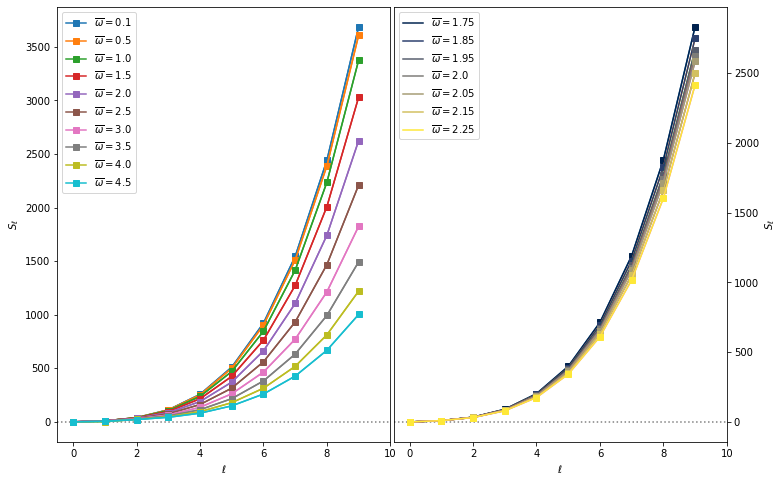

In [40]:
# Plot the results
import matplotlib as mpl

svals = {}
totalvals = {}
# Read the data from the file. Dictionary key is the NN frequency, values are source terms S[l]
with open("data/NNEqualFrequencies_m-4.0.dat", "r") as f:
    lmax = 0
    tmp = []
    for line in f:
        # Read the line that contains the NN frequency value and the number of modes
        if "w =" in line:
            foo = line.strip().split(" = ")
            # Pick out the w value
            dkey = float(foo[1].split()[0])
            # Pick out the l value
            lmax = int(foo[-1])
        # Catch the sum of the source terms and store in separate dictionary
        elif "Sum" in line:
            tsum = line.strip().split(" = ")
            totalvals[dkey] = float(tsum[-1])
        # Otherwise, add the value to the list for that frequency
        else:
            if lmax <= 0:
                #print("Adding element to dictionary:")
                #print("svals[%s] = " % dkey)
                #print(tmp)
                svals[dkey] = tmp
                lmax = 0
                tmp = []
            else:
                bar = line.strip().split()
                tmp.append(float(bar[-1]))
                lmax -= 1

highres = {}
# Read the data from the file. Dictionary key is the NN frequency, values are source terms S[l]
with open("data/NNEqualFrequencies_m-4.0highres.dat", "r") as f:
    lmax = 0
    tmp = []
    for line in f:
        # Read the line that contains the NN frequency value and the number of modes
        if "w =" in line:
            foo = line.strip().split(" = ")
            # Pick out the w value
            dkey = float(foo[1].split()[0])
            # Pick out the l value
            lmax = int(foo[-1])
        # Catch the sum of the source terms and store in separate dictionary
        elif "Sum" in line:
            tsum = line.strip().split(" = ")
            totalvals[dkey] = float(tsum[-1])
        # Otherwise, add the value to the list for that frequency
        else:
            if lmax <= 0:
                #print("Adding element to dictionary:")
                #print("svals[%s] = " % dkey)
                #print(tmp)
                highres[dkey] = tmp
                lmax = 0
                tmp = []
            else:
                bar = line.strip().split()
                tmp.append(float(bar[-1]))
                lmax -= 1


print(highres)

colours = ['C' + str(val) for val in range(10)] * int((len(svals) - 1)/10 + 1)
fig = plt.figure(figsize=(12,8))
gs = GridSpec(2,2,figure=fig,wspace=0.01, hspace=0.2)
ax1 = fig.add_subplot(gs[:,:1])
ax2 = fig.add_subplot(gs[:,-1:])
#ax3 = fig.add_subplot(gs[0,-1:])

# Colourmap for high resolution plot
c = np.arange(1, len(highres) + 1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis)
cmap.set_array([])


# Plot the source terms S[l]
ii = 0
for key in sorted(svals.keys()):
    # Test for nan values caused by division by zero
    if np.any(np.isnan(svals.get(key))):
        temp = svals.get(key)
        xvals = np.arange(len(temp))
        nanvals = np.argwhere(np.isnan(temp))
        # Remove nan values and adjust arrays accordingly
        for indx in nanvals[0]:
            print("NAN value detected:", temp)
            temp = np.delete(temp, [indx])
            xvals = np.delete(xvals, [indx])
        # Recalculate sum with nan values removed
        totalvals[key] = np.sum(temp)
        # Plot adjusted source terms
        ax1.plot(xvals, temp, marker='s', markerfacecolor=colours[ii], 
                 label=r'$\overline{\omega} = $' + str(key))
        ax1.plot(xvals, temp, color=colours[ii])
        #for ax in ax1,ax3:
            #ax.plot(xvals, temp, marker='s', markerfacecolor=colours[ii], 
                 #label=r'$\overline{\omega} = $' + str(key))
            #ax.plot(xvals, temp, color=colours[ii])
    else:
        ax1.plot(np.arange(len(svals.get(key))), svals.get(key)[:], marker='s', markerfacecolor=colours[ii], 
                 label=r'$\overline{\omega} = $' + str(key))
        ax1.plot(np.arange(len(svals.get(key))), svals.get(key)[:], color=colours[ii])
        #for ax in ax1,ax3:
            #ax.plot(np.arange(len(svals.get(key))), svals.get(key)[:], marker='s', markerfacecolor=colours[ii], 
                 #label=r'$\overline{\omega} = $' + str(key))
            #ax.plot(np.arange(len(svals.get(key))), svals.get(key)[:], color=colours[ii])
    ii += 1
    
# Plot the high resolution w data
jj = 0
for key in sorted(highres.keys()):
    ax2.plot(np.arange(len(highres.get(key))), highres.get(key)[:], marker='s', 
             markerfacecolor=cmap.to_rgba(jj + 1), markeredgecolor=cmap.to_rgba(jj + 1))
    ax2.plot(np.arange(len(highres.get(key))), highres.get(key)[:], c=cmap.to_rgba(jj + 1),
                      label=r'$\overline{\omega} = $' + str(key))
    jj += 1

# Plot axis labels and reference line
ax1.hlines(0, -0.5, 10, colors='black', linestyle='dotted', alpha=0.5)
ax2.hlines(0, -0.5, 10, colors='black', linestyle='dotted', alpha=0.5)
ax1.set_xlabel(r'$\ell$')
ax1.set_ylabel(r'$S_{\ell}$')
ax1.legend()
ax1.set_xlim(-0.5,10)
"""
ax3.set_ylim(-1000,1500)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
"""
"""
# Plot sum of source terms up to LMAX
sources = [str(key) for key in sorted(totalvals.keys())]
sums = [abs(totalvals.get(key)) for key in sorted(totalvals.keys())]
x_pos = np.arange(len(sources))
ax2.bar(x_pos, sums, color=colours[:len(sources)])
ax2.set_xticks(x_pos)
ax2.set_xticklabels(sources)
ax2.set_yscale('log')
"""
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel(r'$S_{\ell}$')
ax2.set_xlabel(r'$\ell$')
ax2.legend()
ax2.set_xlim(-0.5,10)

"""
for ax in ax1,ax3:
    ax.set_xlim(-0.5,10)
"""
fname = "NN_equalfreq_sourceterms_m-4_0+zoom.pdf"
plt.savefig("figures/" + fname, transparent=True, format="pdf")
print("Saved figure as", fname)
plt.show()


In [119]:
# Sources for (++) of two NN frequencies adding to an integer

#####################################################
## If either w1 or w2 is an integer, are the X, Y  ##
##  functions returning the correct NN functions?  ##
## How to test for this? Write separate functions? ##
#####################################################

def R_pp(i, w1, w2, l):
    n = (w1 + w2) / 2
    out = - (omega(l) - 2 * n) * Zmin(w1, w2, i, l) / (8 * n) + 0.5 * (w1 * w2 * X(i, w1, w2, l) + \
            (omega(l) - 2 * n) * (w1 * X(w2, w1, i, l) + w2 * X(w1, w2, i, l)) - \
            0.5 * (m * m).real * (V(i, w1, w2, l) + V(i, w2, w1, l) + V(w1, w2, i, l)))
    if omega(l) != w2:
        out -= (1. / 4.) * w2 * Zmin(i, w1, w2, l) / (omega(l) - w2)
    if omega(l) != w1:
        out -= (1. / 4.) * w1 * Zmin(i, w2, w1, l) / (omega(l) - w1)
    if omega(i) != w1:
        out -= (1. / 4.) * (w1 * (H(i, w1, w2, l) + (m * m).real * V(w1, w2, i, l) - \
                2 * w2 ** 2 * X(i, w1, w2, l)) + (omega(l) - 2 * n) * (H(w1, i, w2, l) + \
                (m * m).real * V(i, w2, w1, l) - 2 * w2 ** 2 * X(w1, i, w2, l))) / (omega(l) - w2)
    if omega(i) != w2:
        out -= (1. / 4.) * (w2 * (H(i, w2, w1, l) + (m * m).real * V(w2, w1, i, l) - \
                2 * w1 ** 2 * X(i, w2, w1, l)) + (omega(l) - 2 * n) * (H(w2, i, w1, l) + \
                (m * m).real * V(i, w1, w2, l) - 2 * w1 ** 2 * X(w2, i, w1, l))) / (omega(l) - w1)
    if w1 != w2:
        out -= (w1 * H(w2, w1, i, l) + w2 * H(w1, w2, i, l) + (m * m).real * (w1 * V(w1, i, w2, l) + \
                w2 * V(w2, i, w1, l)) - (omega(l) - 2 * n) ** 2 * (w1 * X(w2, w1, i, l) + \
                w2 * X(w1, w2, i, l))) / (8 * n)
    return out

def R_pm(i, w1, w2, l):
    n = (w1 + w2) / 2
    out = - (1. / 4.) * ((omega(l) + 2 * n) * Zmin(w1, w2, i, l) / (2 * n) + 2 * (omega(l) + 2 * n) * \
            (w1 * X(w2, w1, i, l) + w2 * X(w1, w2, i, l)) - 2 * w1 * w2 * X(i, w1, w2, l) + \
            (m * m).real * (V(w1, w2, i, l) + V(i, w1, w2, l) + V(i, w2, w1, l)) \
            - w1 * (H(i, w1, w2, l) + (m * m).real * V(w1, w2, i, l) - \
                2 * w2 ** 2 * X(i, w1, w2, l)) / (omega(l) + w2) \
            + (omega(l) + 2 * n) * (H(w1, i, w2, l) + (m * m).real * V(i, w2, w1, l) - \
                2 * w2 ** 2 * X(w1, i, w2, l)) / (omega(l) + w2) \
            - w2 * (H(i, w2, w1, l) + (m * m).real * V(w2, w1, i, l) - \
                2 * w1 ** 2 * X(i, w2, w1, l)) / (omega(l) + w1) \
            + (omega(l) + 2 * n) * (H(w2, i, w1, l) + (m * m).real * V(i, w1, w2, l) - \
                2 * w1 ** 2 * X(w2, i, w1, l)) / (omega(l) + w1))
    if w2 != omega(l):
        out += w1 * w2 * (omega(l) + 2 * n) * (X(w2, w1, i, l) - X(l, i, w1, w2)) / (omega(l) + w2)
    if w1 != omega(l):
        out += w1 * w2 * (omega(l) + 2 * n) * (X(w1, w2, i, l) - X(l, i, w2, w1)) / (omega(l) + w1)
    return out
    
def R_mp(i, w1, w2, l):
    n = (w1 + w2) / 2
    out = - (1. / 2.) * ((2 * n - omega(l)) * (w1 * X(w2, w1, i, l) + w2 * X(w1, w2, i, l)) \
            - w1 * w2 * X(i, w1, w2, l))
    if omega(i) != omega(l):
        out += (1. / 4.) * (2 * n - omega(l)) * Zmin(w1, w2, i, l) / (2 * n)
    if w1 != omega(l):
        out += (1. / 4.) * w1 * Zpl(i, w2, w1, l) / (omega(l) - w1)
    if w2 != omega(l):
        out += (1. / 4.) * w2 * Zpl(i, w1, w2, l) / (omega(l) - w2)
    if w1 != omega(i):
        out += (1. / 4.) * (w1 * (H(i, w1, w2, l) - 2 * w2 ** 2 * X(i, w1, w2, l)) - \
                (2 * n - omega(l)) * (H(w1, i, w2, l) - 2 * w2 ** 2 * X(w1, i, w2, l))) / (omega(i) - w1)
    if w2 != omega(i):
        out += (1. / 4.) * (w2 * (H(i, w2, w1, l) - 2 * w1 ** 2 * X(i, w2, w1, l)) - \
                (2 * n - omega(l)) * (H(w2, i, w1, l) - 2 * w1 ** 2 * X(w2, i, w1, l))) / (omega(i) - w2)
    if w1 != w2:
        out -= (w1 * H(w2, w1, i, l) + w2 * H(w1, w2, i, l) - \
                2 * (2 * n - omega(l)) ** 2 * (w1 * X(w2, w1, i, l) + w2 * X(w1, w2, i, l))) / (8 * n)
    return out

def Tee(w1, w2, l):
    n = (w1 + w2) / 2
    return 0.5 * omega(l) ** 2 * (Zpl_tilde(w1, w1, l) + Zpl_tilde(w2, w2, l)) - 0.5 * (H(w1, w1, l, l) \
            + H(w2, w2, l, l) + (m * m).real * (V(l, w1, w1, l) + V(l, w2, w2, l)) \
            - 2 * omega(l) ** 2 * (X(w1, w1, l, l) + X(w2, w2, l, l)) \
            + 4 * omega(l) ** 2 * (w1 ** 2 * P(l, l, w1) + w2 ** 2 * P(l, l, w2)) + 2 * w1 ** 2 * Emm(l, l, w1) \
            + 2 * w2 ** 2 * Emm(l, l, w2) + 2 * (m * m).real * (w1 ** 2 * Que(l, l, w1) + w2 ** 2 * Que(l, l, w2))) 
                                                          

In [85]:
# Test each channel for naturally vanishing resonances
def atoi_ppchannel(n, w1, Lmax):
    if not isinstance(n, int):
        print("ERROR: n must be an integer")
        return None
    else:
        w2 = float(2*n - w1)
        outval = np.zeros((Lmax + 1,), dtype=np.double)
        for l in range(Lmax + 1):
            if (l - n >= 0):
                outval[l] += R_pp(int(l - n), float(w1), w2, int(l))
            else:
                pass
            #print("S[%d] = %e" % (l, outval[l]))
        #print("Sum_0^%d = %e" % (Lmax, np.sum(outval)))
    return outval

lmax = 10
n = 4
w1 = 1.5
print("(++) resonances for Lmax = %d, n = %d, w1 = %e, w2 = %e:" % (lmax, n, w1, 2*n - w1))
print(atoi_ppchannel(n, w1, lmax))

(++) resonances for Lmax = 10, n = 4, w1 = 1.500000e+00, w2 = 6.500000e+00:
[ 0.          0.          0.          0.         -0.02975616 -0.09277118
 -0.19248072 -0.33116789 -0.50989911 -0.72924713 -0.9895542 ]


In [86]:
# Test each channel for naturally vanishing resonances
def atoi_pmchannel(n, w1, Lmax):
    if not isinstance(n, int):
        print("ERROR: n must be an integer")
        return None
    else:
        w2 = float(2*n - w1)
        outval = np.zeros((Lmax + 1,), dtype=np.double)
        for l in range(Lmax + 1):
            outval[l] += R_pm(int(l + n), float(w1), w2, int(l))
            #print("S[%d] = %e" % (l, outval[l]))
        #print("Sum_0^%d = %e" % (Lmax, np.sum(outval)))
    return outval

lmax = 10
n = 4
w1 = 1.5
print("(+-) resonances for Lmax = %d, n = %d, w1 = %e, w2 = %e" % (lmax, n, w1, 2*n - w1))
print(atoi_pmchannel(n, w1, lmax))

(+-) resonances for Lmax = 10, n = 4, w1 = 1.500000e+00, w2 = 2n - w1


array([-0.05460549, -0.3659559 , -0.71339794, -1.0282735 , -1.28584577,
       -1.47541536, -1.59172412, -1.63193479, -1.59440318, -1.47812125,
       -1.28244207])

In [123]:
# Test each channel for naturally vanishing resonances
def atoi_mpchannel(n, w1, Lmax):
    if not isinstance(n, int):
        print("\nERROR: n must be an integer")
        return None
    else:
        if (m * m).real != 0:
            print("\nERROR: (-+) channel only contributes when m^2=0")
            return None
        else:
            w2 = float(2*n - w1)
            outval = np.zeros((Lmax + 1,), dtype=np.double)
            for l in range(Lmax + 1):
                if (n >= l + d):
                    outval[l] += R_mp(int(n - l - d), float(w1), w2, int(l))
                else:
                    pass
                #print("S[%d] = %e" % (l, outval[l]))
            #print("Sum_0^%d = %e" % (Lmax, np.sum(outval)))
    return outval

lmax = 10
n = 4
w1 = 1.5
print("(+-) resonances for Lmax = %d, n = %d, w1 = %e, w2 = %e" % (lmax, n, w1, 2*n - w1))
print(atoi_mpchannel(n, w1, lmax))
print("(+-) resonances for Lmax = %d, n = %d, w1 = %e, w2 = %e" % (lmax, n, 2*n - w1, w1))
print(atoi_mpchannel(n, 2*n - w1, lmax))

(+-) resonances for Lmax = 10, n = 4, w1 = 1.500000e+00, w2 = 6.500000e+00
[0.33591459 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
(+-) resonances for Lmax = 10, n = 4, w1 = 6.500000e+00, w2 = 1.500000e+00
[0.33591459 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


In [104]:
# Test each channel for naturally vanishing resonances
def atoi_tchannel(n, w1, Lmax):
    if not isinstance(n, int):
        print("\nERROR: n must be an integer")
        return None
    else:
        w2 = float(2*n - w1)
        outval = np.zeros((Lmax + 1,), dtype=np.double)
        for l in range(Lmax + 1):
            outval[l] += Tee(float(w1), w2, int(l))
            #print("S[%d] = %e" % (l, outval[l]))
        #print("Sum_0^%d = %e" % (Lmax, np.sum(outval)))
    return outval

lmax = 10
n = 4
w1 = 1.5
print("Tee resonances for Lmax = %d, n = %d, w1 = %e, w2 = %e" % (lmax, n, w1, 2*n - w1))
print(atoi_tchannel(n, w1, lmax))

Tee resonances for Lmax = 10, n = 4, w1 = 1.500000e+00, w2 = 6.500000e+00

ERROR: no NN frequency 1.500000 found in bdata


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [94]:
# Examine different values of n by scanning over
# NN frequency values that add to 2n

# Try a step size for NN frequencies -- technically an infinite number of terms?
wstep = 0.5
n = 4
w1 = np.arange(wstep, 2*n, wstep)
datafile = "data/NNAddToInteger_ppchannel_n" + str(n) + "_m" + str((m * m).real) + ".dat"
with open(datafile, "w") as f:
    for val1 in w1:
        prog = 100 - (w1[-1] - val1) / (w1[-1] - w1[0]) * 100
        print('\rPercent complete: ' + '{:03.1f}'.format(prog) + '%', end='\r')
        result = atoi_ppchannel(int(n), float(val1), 10)
        f.write("Computing source terms for two NN modes with w1 = {:f}".format(val1) +
                    " and w2 = {:f}".format(2*n - val1) + " up to l = 10\n")
        for i in range(len(result)):
            f.write("S[" + str(i) + "] = {:e}\n".format(result[i]))
        f.write("Sum_0^{:d} = ".format(len(result)) + "{:e}\n".format(np.sum(result)))
print("Wrote data to", f.name)

Wrote data to data/NNAddToInteger_ppchannel_n4_m0.0.dat


In [89]:
# Examine different values of n by scanning over
# NN frequency values that add to 2n

# Try a step size for NN frequencies -- technically an infinite number of terms?
wstep = 0.25
n = 4
w1 = np.arange(wstep, 2*n, wstep)
datafile = "data/NNAddToInteger_pmchannel_n" + str(n) + "_m" + str((m * m).real) + ".dat"
with open(datafile, "w") as f:
    for val1 in w1:
        prog = 100 - (w1[-1] - val1) / (w1[-1] - w1[0]) * 100
        print('\rPercent complete: ' + '{:03.1f}'.format(prog) + '%', end='\r')
        result = atoi_pmchannel(int(n), float(val1), 10)
        f.write("Computing source terms for two NN modes with w1 = {:f}".format(val1) +
                    " and w2 = {:f}".format(2*n - val1) + " up to l = 10\n")
        for i in range(len(result)):
            f.write("S[" + str(i) + "] = {:e}\n".format(result[i]))
        f.write("Sum_0^{:d} = ".format(len(result)) + "{:e}\n".format(np.sum(result)))
print("Wrote data to", f.name)

Wrote data to data/NNAddToInteger_pmchannel_n4_m0.0.dat


In [90]:
# Examine different values of n by scanning over
# NN frequency values that add to 2n

# Try a step size for NN frequencies -- technically an infinite number of terms?
wstep = 0.25
n = 4
L = 10
w1 = np.arange(wstep, 2*n, wstep)
datafile = "data/NNAddToInteger_mpchannel_n" + str(n) + "_m" + str((m * m).real) + ".dat"
with open(datafile, "w") as f:
    for val1 in w1:
        prog = 100 - (w1[-1] - val1) / (w1[-1] - w1[0]) * 100
        print('\rPercent complete: ' + '{:03.1f}'.format(prog) + '%', end='\r')
        result = atoi_mpchannel(int(n - L - d), float(val1), int(L))
        f.write("Computing source terms for two NN modes with w1 = {:f}".format(val1) +
                    " and w2 = {:f}".format(2*n - val1) + " up to l = {:d}\n".format(L))
        for i in range(len(result)):
            f.write("S[" + str(i) + "] = {:e}\n".format(result[i]))
        f.write("Sum_0^{:d} = ".format(len(result)) + "{:e}\n".format(np.sum(result)))
print("Wrote data to", f.name)

Wrote data to data/NNAddToInteger_mpchannel_n4_m0.0.dat


In [111]:
# Examine different values of n by scanning over
# NN frequency values that add to 2n

# Try a step size for NN frequencies -- technically an infinite number of terms?
wstep = 0.5
n = 4
w1 = np.arange(0.25, 2*n, wstep)
datafile = "data/NNAddToInteger_tchannel_n" + str(n) + "_m" + str((m * m).real) + ".dat"
with open(datafile, "w") as f:
    for val1 in w1:
        prog = 100 - (w1[-1] - val1) / (w1[-1] - w1[0]) * 100
        print('\rPercent complete: ' + '{:03.1f}'.format(prog) + '%', end='\r')
        result = atoi_tchannel(int(n), float(val1), 10)
        f.write("Computing source terms for two NN modes with w1 = {:f}".format(val1) +
                    " and w2 = {:f}".format(2*n - val1) + " up to l = 10\n")
        for i in range(len(result)):
            f.write("S[" + str(i) + "] = {:e}\n".format(result[i]))
        f.write("Sum_0^{:d} = ".format(len(result)) + "{:e}\n".format(np.sum(result)))
print("Wrote data to", f.name)

Wrote data to data/NNAddToInteger_tchannel_n4_m0.0.dat


In [ ]:
# Use values from all the channels to determine the total
# source term for two NN modes that add to an integer

def atoi_source(n, w1, Lmax):
    if not isinstance(n, int):
        print("\nERROR: n must be an integer")
        return None
    else:
        w2 = float(2*n - w1)
        outval = np.zeros((Lmax + 1,), dtype=np.double)
        for l in range(Lmax + 1):
            outval[l] += Tee(float(w1), w2, int(l)) + R_pm(int(l + n), float(w1), w2, int(l))
            if (l >= n):
                outval[l] += R_pp(int(l - n), float(w1), w2, int(l))
            if (m * m).real == 0 and n >= l + d:
                outval[l] += R_mp(int(n - l - d), float(w1), w2, int(l))
            #print("S[%d] = %e" % (l, outval[l]))
        #print("Sum_0^%d = %e" % (Lmax, np.sum(outval)))
    return outval

lmax = 10
n = 4
w1 = 1.5
print("All atoi resonances for m^2 = %f, Lmax = %d, n = %d, w1 = %e, w2 = 2n - w1" % ((m * m).real, lmax, n, w1))
atoi_source(n, w1, lmax)

In [160]:
# Examine different values of n by scanning over
# NN frequency values that add to 2n

# Try a step size for NN frequencies -- technically an infinite number of terms?
wstep = 0.25
n = 2
w1 = np.arange(wstep, 2*n, wstep)
datafile = "data/NNAddToInteger_source_n" + str(n) + "_m" + str((m * m).real) + ".dat"
with open(datafile, "w") as f:
    for val1 in w1:
        prog = 100 - (w1[-1] - val1) / (w1[-1] - w1[0]) * 100
        print('\rPercent complete: ' + '{:03.1f}'.format(prog) + '%', end='\r')
        result = atoi_source(int(n), float(val1), 10)
        f.write("Computing source terms for two NN modes with w1 = {:f}".format(val1) +
                    " and w2 = {:f}".format(2*n - val1) + " up to l = 10\n")
        for i in range(len(result)):
            f.write("S[" + str(i) + "] = {:e}\n".format(result[i]))
        f.write("Sum_0^{:d} = ".format(len(result)) + "{:e}\n".format(np.sum(result)))
print("Wrote data to", f.name)

Wrote data to data/NNAddToInteger_source_n2_m-4.0.dat


Saved figure as NNAddToInteger_source_n2_m-4_0.pdf


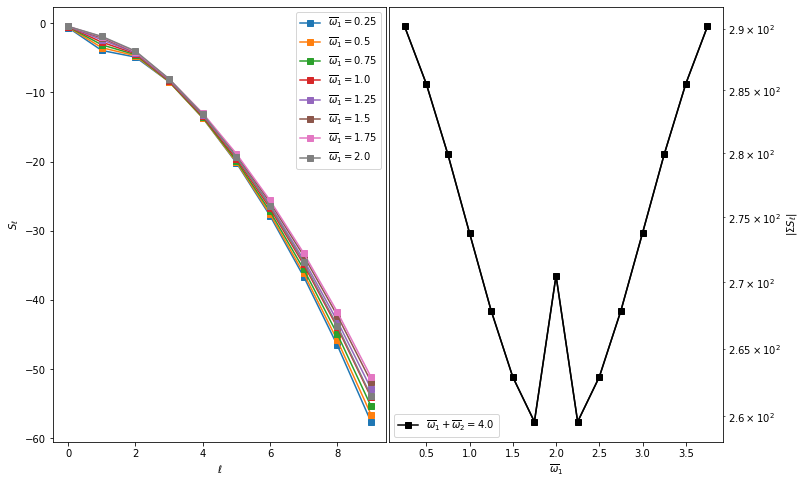

In [161]:
# Plot the results
svals = {}
totalvals = {}
# Read the data from the file. Dictionary key is the NN frequency, values are source terms S[l]
datafile = "data/NNAddToInteger_source_n2_m-4.0.dat"
if not os.path.isfile(datafile):
    print("\nERROR: couldn't find datafile", datafile)
else:
    pass
with open(datafile, "r") as f:
    lmax = 0
    tmp = []
    for line in f:
        # Read the line that contains the NN frequency value and the number of modes
        if "w1 =" in line:
            foo = line.strip().split(" = ")
            # Pick out the w1 and w2 values
            dkey = (float(foo[1].split()[0]), float(foo[2].split()[0]))
            # Pick out the l value
            lmax = int(foo[-1])
        # Catch the sum of the source terms and store in separate dictionary
        elif "Sum" in line:
            tsum = line.strip().split(" = ")
            totalvals[dkey] = float(tsum[-1])
        # Otherwise, add the value to the list for that frequency
        else:
            if lmax <= 0:
                svals[dkey] = tmp
                lmax = 0
                tmp = []
            else:
                # Lines containing separators can be skipped
                if "--" in line:
                    pass
                else:
                    bar = line.strip().split()
                    tmp.append(float(bar[-1]))
                    lmax -= 1

# Check for symmetry
for key in sorted(svals.keys()):
    w1, w2 = key[0], key[1]
    data1 = svals.get(key)
    reverse = (w2, w1)
    if reverse in svals:
        data2 = svals.get(reverse)
        diff = [x - y for x,y in zip(data1,data2)]
        if np.any(diff):
            print("\nERROR: symmetry violated")
            print("(%f, %f):" % (w1, w2), data1)
            print("(%f, %f):" % (reverse[0], reverse[1]), data2)
        else:
            pass
            #print("Confirmed symmetric: (%f, %f) = (%f, %f)" % (w1, w2, reverse[0], reverse[1]))
    else:
        print("\nERROR: couldn't find the matching key for (%f, %f)" % (w1, w2))

                    
colours = ['C' + str(val) for val in range(10)] * int((len(svals) - 1)/10 + 1)
ls = ['-', '--']
fig = plt.figure(figsize=(12,8))
gs = GridSpec(2,2,figure=fig, wspace=0.01, hspace=0.18)
ax1 = fig.add_subplot(gs[:,:1])
#ax3 = fig.add_subplot(gs[0,:1])
ax2 = fig.add_subplot(gs[:,1:])

# Plot the source terms S[l]
ii = 0
jj = 0
for key in sorted(svals.keys()):
    # Test for nan values caused by division by zero
    if np.any(np.isnan(svals.get(key))):
        print("Entering NAN condition")
        temp = svals.get(key)
        xvals = np.arange(len(temp))
        nanvals = np.argwhere(np.isnan(temp))
        # Remove nan values and adjust arrays accordingly
        for indx in nanvals[0]:
            print("NAN found at" + str(key) + ":", temp)
            temp = np.delete(temp, [indx])
            xvals = np.delete(xvals, [indx])
        # Recalculate sum with nan values removed
        totalvals[key] = np.sum(temp)
        # Plot adjusted source terms
        ax1.plot(xvals, temp, marker='s', markerfacecolor=colours[ii], 
                 label=r'$\overline{\omega}_1 = $' + str(key[0]))
        ax1.plot(xvals, temp, color=colours[ii])
    else:
        # If there are more entries than unique colours, change the line type
        if ii == 10:
            jj += 1
        if key[0] > key[1]:
            # Data is symmetric, so only plot half of it for clarity
            pass
        else:
            ax1.plot(np.arange(len(svals.get(key))), svals.get(key)[:], marker='s', color=colours[ii], 
                     label=r'$\overline{\omega}_1 = $' + str(key[0]), linestyle=ls[jj])
            ii += 1
        
    
ax1.set_xlabel(r'$\ell$')
ax1.set_ylabel(r'$S_\ell$')
ax1.legend()


# Plot sum of source terms up to LMAX in two axes
X = [key[0] for key in sorted(totalvals.keys())]
Y = [key[1] for key in sorted(totalvals.keys())]
N = X[0] + Y[0]
Z = [abs(totalvals.get(key)) for key in sorted(totalvals.keys())]

ax2.plot(X, Z, marker='s', color='k', 
         label=r'$\overline{\omega}_1 + \overline{\omega}_2 = $' + str(N))
ax2.plot(X, Z, color='k')

ax2.set_xlabel(r'$\overline{\omega}_1$')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel(r'$| \Sigma S_\ell|$')
ax2.set_yscale('log')
ax2.legend()


fname = "NNAddToInteger_source_n2_m-4_0.pdf"
plt.savefig("figures/" + fname, transparent=True, format="pdf")
print("Saved figure as", fname)
plt.show()
